# Metodología 

## Nuestro problema

Tal como se planteó nuestro problema es el de determinar si un par de firmas (imágenes) coinciden o no (son del mismo autor).

A diferencia del problema de signature verification donde hay que determinar si una firma pertenece al autor que declara ser (conociendo previamente ciertas firmas para cada autor), en nuestro problema es posible (y probable) que las firmas sobre la que aplicaremos nuestra solución sean de autores completamente distintos a los que usamos para entrenar. Es por ello que no podemos hacer como el trabajo de Parodi donde se entrena un clasificador binario para cada autor.

Nuestra entrada será entonces pares de firmas. Y nuestra salida un booleano que indicará si es clasificado como coincidencia o no.

## Soluciones

Una solución al problema consiste en un par de funciones fit y predict.
- predict(path_img_1, path_img_2) : Bool determinará si dos firmas son una coincidencia o no.
- fit(fns, cls) entrenará la solución utilizando un conjunto de imágenes para las cuáles se conocen sus repectivos autores.

## Experimento

### Firmas para desarrollo y testeo final
Cada experimento consiste en un 3-upla de (dev, test, test_ds).
Tanto dev como test son duplas (fns, cls) con path hacia imágenes y clases respectivamente.
Como su nombre indica los elementos de dev pueden usarse para entrenar. Aplicaremos fit de una solución sobre ellos.

### Pares de firmas para testeo final
Los elementos de test se usarán para evaluar la performance de la solución. Como nuestra entrada son pares de firmas test_ds consiste en 3-uplas (idx_1, idx_2, bool) donde el booleano determina si test\[idx_1\], test\[idx_2\] es un matcheo o no. Es importante usar las mismas 3-uplas para evaluar cada solución final de modo que la comparación sea correcta ya que la métrica podría variar dependiendo de la elección de los pares de firmas.

#### Generación de pares
En la generación de pares se generarán por cada  cls_sampling_limit 

### Desarrollo = entrenamiento + validación
Del conjunto de firmas dedicadas al desarrollo (dev) se obtendrán tanto los subconjuntos de entrenamiento (que se utilizarán para encontrar los parámetros del modelo) como de validación (que se utilizarán para encontrar los hiperparámetros).

La cantidad de clases (autores) distintas en el conjunto de desarrollo puede ser escasa (como suecede en el experimento 1). En dichos casos las métricas en validación pueden variar demasiado dependiendo de la elección de partición entrenamiento/validación, lo cuál hace sensible a la elección de los hiperparémtros también a la elección de dicha partición. Es por eso que utilizarmos un 5-folding cross validation sobre el conjunto de desarrollo para generar 5 particiones entrenamiento/validación, de modo que la elección de hiperparámetros sea más robusta. Guardaremos estas particiones en el campo split[0..4] del experimento. Cada uno de ellos será una dupla (train, valid) donde cada uno consistirá (al igual que dev) de una dupla (fns, cls).

Es importante si vamos a comparar el score de validación de varios modelos, fijar también el emparejamientos de elementos (recordemos que nuestra solución toma pares) para los subconjuntos de validación (tal como hicimos para el test). Es por ello que pre-computaremos y guardaremos en el experimentos split_valid_ds[0..5] que serán los emparejamoentos (3-uplas (idx1, idx2, bool)) para el valid respectivo al split en cuestión.

# Conjuntos de datos

## Construcción del dataset de tuplas

Es importante observar que cada elemento aparece más de una vez en el conjunto de datos (debido al tuplamiento). Depende de cómo trabaje el modelo y como se construyan las features de las tuplas, pero es posible que al ver "demasiadas veces" un ejemplo aumente la posibilidad de sobreajuste: aún teniendo un número grande de tuplas el número de elementos es significativamente menor. Por lo cuál se desprende que es importante decidir cómo (y por ende cuántas) tuplas vamos a confeccionar.

Al armar las parejas en el conjunto de test y validación se construyó siempre conjuntos balanceados: hay tantas coincidencias como no coincidencias.
Observar que si se hubieran generado todas las parejas posibles el conjunto en general contendría muchas mas no coincidencias que coincidencias.

Lo que se ha hecho para generar coincidencias es para cada clase armar parejas sin repetirlas (sin considerar orden). cls_sampling_limit es un parémtro que indica que limita la cantidad de veces que un elemento aparece en las parejas auténticas. Es a lo sumo el tamaño de la clase más chica.

Para generar pares no coincidentes se ha tomado luego para cada elemento otros elementos no coincidentes (tantos como coincidentes se hayan tomado dejando el conjunto balanceado como queremos.

## Conjunto de datos - "Experimento 1"

Para este experimento se utilizaron los dataset NISDCC y NFI (usados en Sigcomp 2009).
Como NFI consta de 80 autores y NISDCC solo de 12 autores. 

Presumiblemente las diferencias entre los mismos probablemente sean mayores que las diferencias internas de cada uno (en cuánto al tipo de trazo, calidad de las firmas, metodología de la construcción).

Para el conjunto de test se deseótener un número razonables de autores en test (al menos 30) y a la vez utilizar uno de los dataset exclusivamente para test. Es por ello que se utilizó:

- 60 autores de NFI como conjunto de desarrollo.
- NISDCC + los 20 autores restantes de NFI como conjunto de test.


## Conjunto de datos - "Experimento 2"

Para este experimento se agregó a los datasets ya nombrados NISDCC y NFI, el dataset de firmas CEDAR.



In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import sys; print(sys.version)

3.8.2 (default, Mar 26 2020, 15:53:00) 
[GCC 7.3.0]


In [3]:
from import_all import *

In [3]:
def experiment_2_get_files(p): 
    if 'sigcomp2009' in str(p): return L(ds_sigcomp2009.get_authentic_signatures(p))
    return get_image_files(p)

def experiment_2_get_y(fp):
    if 'sigcomp2009' in str(fp): return ds_sigcomp2009.get_y(fp)
    assert 'cedar' in str(fp)
    return ds_cedar.get_y(fp)

def experiment_2_is_valid(fp):
    return 'sigcomp2009' not in str(fp)

es2 = get_elements(['./data/cedar', './data/sigcomp2009'], 
                   experiment_2_get_files, 
                   experiment_2_get_y,
                   experiment_2_is_valid)

e2 = Experiment(*es2, cls_sampling_limit_validation=5, cls_sampling_limit_test=24)
save_pickle('./experiment_2.pkl',e2)

N dev files: 1000 | N test files 1320 | files test/ratio: 0.5689655172413793
N dev classes: 91 | N test classes: 55 | classes test/ratio: 0.3767123287671233
cls_sampling_limit_test = 24
Min class size dev: 5 | Min class size test: 24
Max class size dev: 12 | Max class size test: 24
N pairs test: 30360 | true ratio: 0.5
N splits train/validation:(821/179) (834/166) (841/159) (848/152) (834/166) (822/178)
N classes train/validation:(76/15) (76/15) (76/15) (76/15) (76/15) (75/16)
Len split pairs: [1340, 1210, 1140, 1070, 1210, 1300]
true ratio split pairs: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [4]:
# Generate Experiment 1 Dataset
es1 = get_elements('./data/sigcomp2009', 
                   ds_sigcomp2009.get_authentic_signatures, 
                   ds_sigcomp2009.get_y,
                   lambda fn : 'NISDCC' in fn.name or int(ds_sigcomp2009.get_y(fn)[-3:])<=20)
e1 = Experiment(*es1, cls_sampling_limit_validation=12, cls_sampling_limit_test=5)
save_pickle('./experiment_1.pkl',e1)

N dev files: 731 | N test files 269 | files test/ratio: 0.269
N dev classes: 61 | N test classes: 30 | classes test/ratio: 0.32967032967032966
cls_sampling_limit_test = 5
Min class size dev: 11 | Min class size test: 5
Max class size dev: 12 | Max class size test: 12
N pairs test: 1790 | true ratio: 0.5
N splits train/validation:(611/120) (611/120) (611/120) (611/120) (612/119) (599/132)
N classes train/validation:(51/10) (51/10) (51/10) (51/10) (51/10) (50/11)
Len split pairs: [1320, 1320, 1320, 1320, 1298, 1452]
true ratio split pairs: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [7]:
e1 = load_pickle('./experiment_1.pkl')

In [5]:
e=e1

In [10]:
configuration_1 = {
    'FEATURE_MIX_METHOD' :'FeatureObtainer_Difference',
    'FFT' : 'OFF',
    'N_DIVISIONS' : '16',
    'DATASET_AUGMENTATION' : 'ON',
    'SCALER_METHOD' : 'NONE',
}
i=1
Xm,ym,Xth,Yth,Xv,yv = parodi_configurate(configuration_1, e.split[i][0], set(e.split[(i+1)%6][1][1]), e.split[i][1], e.split_valid_ds[i])
Xm.shape,ym.shape,Xth.shape,Yth.shape,Xv.shape,yv.shape

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611


((91652, 48), (91652,), (1320, 48), (1320,), (1320, 48), (1320,))

In [6]:
N_FOLDS = len(e.split)
ID_COLUMNS = ['id', 'config_id', 'split_n']
CONFIG_COLUMNS = L(RF_GRID_SEARCH_OPTIONS.keys())
DATA_COLUMNS =  ['oob_score'] +  [ p+'_'+s for p in ['train', 'threshold', 'valid'] for s in ['precision', 'recall', 'accuracy', 'f1']]

In [7]:
class NumpySet:
    def __init__(self, cls, X, y, recall_required):
        p = get_decision_values(cls,X)
        _, th, (precs, recs,ths) = precision_score_recall_constrained(y,p,recall_required)
        f1s = 2*recs*precs / (recs+precs)
        store_attr('X,y,p,recs,precs,f1s,ths,th', self)

rows = []
for config_idx, config in tqdm.tqdm(list(enumerate(iterate_configurations(RF_GRID_SEARCH_OPTIONS)))):
    for split_idx in range(N_FOLDS):
        # Data loading
        Xm,ym,Xt,yt,Xv,yv = parodi_configurate(config, 
                                       e.split[split_idx][0],
                                       set(e.split[(split_idx+1)%N_FOLDS][1][1]),
                                       e.split[split_idx][1], 
                                       e.split_valid_ds[split_idx],
                                       augment_ratio=4)
        # Training
        rf = RandomForestClassifier(oob_score=True,n_jobs=-1,n_estimators=100)
        rf.fit(Xm,ym)
        # Predict
        m,t,v = [ NumpySet(rf,X,y,0.9) for X,y in [ (Xm,ym), (Xt,yt), (Xv,yv) ] ]
        m.metrics, t.metrics, v.metrics = [precision_recall_accuracy_f1_scores(ns.p,ns.y,t.th) for ns in [m,t,v]]
        m.title, t.title, v.title = 'Model Train Set', 'Threshold Train Set', 'Validation Set'
        rows.append([len(rows),config_idx,split_idx,
                    *CONFIG_COLUMNS.map(lambda col : config[col]),
                    rf.oob_score_,
                    *m.metrics,
                    *t.metrics,
                    *v.metrics])

  0%|          | 0/40 [00:00<?, ?it/s]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


  2%|▎         | 1/40 [00:06<03:59,  6.13s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


  5%|▌         | 2/40 [02:30<55:30, 87.63s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


  8%|▊         | 3/40 [02:39<31:46, 51.54s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 10%|█         | 4/40 [05:51<1:04:14, 107.08s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 12%|█▎        | 5/40 [06:02<42:19, 72.55s/it]   

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 15%|█▌        | 6/40 [10:35<1:19:36, 140.49s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 18%|█▊        | 7/40 [10:50<54:46, 99.59s/it]   

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 20%|██        | 8/40 [17:20<1:42:21, 191.93s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 22%|██▎       | 9/40 [17:42<1:11:45, 138.87s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 25%|██▌       | 10/40 [27:14<2:16:18, 272.60s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 28%|██▊       | 11/40 [27:20<1:32:21, 191.09s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 30%|███       | 12/40 [29:44<1:22:25, 176.62s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 32%|███▎      | 13/40 [29:52<56:33, 125.69s/it]  

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 35%|███▌      | 14/40 [9:05:19<68:05:52, 9428.93s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 38%|███▊      | 15/40 [9:05:31<45:46:06, 6590.65s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 40%|████      | 16/40 [9:11:33<31:26:14, 4715.59s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 42%|████▎     | 17/40 [9:11:51<21:06:09, 3303.02s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 45%|████▌     | 18/40 [9:19:13<14:55:56, 2443.47s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 48%|████▊     | 19/40 [9:19:37<10:00:52, 1716.77s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 50%|█████     | 20/40 [9:30:15<7:44:15, 1392.75s/it] 

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 52%|█████▎    | 21/40 [9:30:21<5:09:16, 976.67s/it] 

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 55%|█████▌    | 22/40 [9:32:55<3:38:53, 729.64s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 57%|█████▊    | 23/40 [9:33:04<2:25:28, 513.42s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 60%|██████    | 24/40 [9:36:29<1:52:16, 421.05s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 62%|██████▎   | 25/40 [9:36:42<1:14:35, 298.34s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 65%|██████▌   | 26/40 [9:41:32<1:09:03, 295.96s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 68%|██████▊   | 27/40 [9:41:48<45:56, 212.05s/it]  

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 70%|███████   | 28/40 [9:49:54<58:48, 294.08s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 492 | # train threshold signatures 119 | check 611
# train signatures: 612 | # train model signatures 480 | # train threshold signatures 132 | check 612
# train signatures: 599 | # train model signatures 479 | # train threshold signatures 120 | check 599


 72%|███████▎  | 29/40 [9:50:20<39:12, 213.84s/it]

# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611
# train signatures: 611 | # train model signatures 491 | # train threshold signatures 120 | check 611


 72%|███████▎  | 29/40 [9:53:40<3:45:11, 1228.31s/it]


KeyboardInterrupt: 

In [8]:
vc=['valid_recall', 'valid_precision','valid_accuracy', 'valid_f1']
df=pd.DataFrame(data=rows,columns=ID_COLUMNS+CONFIG_COLUMNS+DATA_COLUMNS)
display(df[vc])
df.describe()[vc]

,valid_recall,valid_precision,valid_accuracy,valid_f1
0,0.968182,0.776428,0.844697,0.861767
1,0.816667,0.910473,0.868182,0.861022
2,0.792424,0.938959,0.870455,0.859491
3,0.859091,0.992995,0.926515,0.921202
4,0.979969,0.894515,0.932203,0.935294
...,...,...,...,...
170,0.846970,0.916393,0.884848,0.880315
171,0.907576,0.934477,0.921970,0.920830
172,0.942989,0.844138,0.884438,0.890830
173,0.859504,0.806202,0.826446,0.832000


,valid_recall,valid_precision,valid_accuracy,valid_f1
count,175.000000,175.000000,175.000000,175.000000
mean,0.890805,0.862418,0.868279,0.872413
std,0.058952,0.081133,0.046693,0.040782
min,0.784848,0.702059,0.782576,0.798491
25%,0.845455,0.799873,0.823898,0.834817
50%,0.877273,0.866481,0.877504,0.874214
75%,0.957216,0.933164,0.914452,0.913176
max,0.983333,0.996534,0.941667,0.940221


In [9]:
df.to_csv('tabla.csv',index=False)

In [47]:


plots_prec_rec(m, t.th, figuresize=(9,6))
plots_prec_rec(v, t.th, figuresize=(9,6))
plots_prec_rec(t, t.th, figuresize=(9,6))

AttributeError: 'NumpySet' object has no attribute 'title'

In [42]:
th_cls =  L(set(e.split[1][1][1]))
th_cls = th_cls[:len(th_cls)//5]
th_cls += L(set(e.split[0][1][1]))
len(th_cls)

12

In [43]:
len(set(e.dev[1]))/12

5.083333333333333

In [49]:
        m.title, t.title, v.title = 'Model Train Set', 'Threshold Train Set', 'Validation Set'


In [45]:
# Data loading
Xm,ym,Xth,yth,Xv,yv = parodi_configurate(config, 
                               e.dev,
                               th_cls,
                               e.test, 
                               e.test_ds,
                               augment_ratio=4)
# Training
rf = RandomForestClassifier(oob_score=True,n_jobs=-1,n_estimators=100)
rf.fit(Xm,ym)
# Predict
m,t,v = [ NumpySet(rf,X,y,0.9) for X,y in [ (Xm,ym), (Xth,yth), (Xv,yv) ] ]
m.metrics, t.metrics, v.metrics = [precision_recall_accuracy_f1_scores(ns.p,ns.y,t.th) for ns in [m,t,v]]
m.title, t.title, v.title = 'Model Train Set', 'Threshold Train Set', 'Validation Set'

rows2=[]
rows2.append([len(rows),config_idx,split_idx,
            *CONFIG_COLUMNS.map(lambda col : config[col]),
            rf.oob_score_,
            *m.metrics,
            *t.metrics,
            *v.metrics])

# train signatures: 731 | # train model signatures 588 | # train threshold signatures 143 | check 731


In [46]:
vc=['valid_recall', 'valid_precision','valid_accuracy', 'valid_f1']
df=pd.DataFrame(data=rows2,columns=ID_COLUMNS+CONFIG_COLUMNS+DATA_COLUMNS)
display(df[vc])
df.describe()[vc]

,valid_recall,valid_precision,valid_accuracy,valid_f1
0,0.892737,0.879956,0.885475,0.886301


,valid_recall,valid_precision,valid_accuracy,valid_f1
count,1.000000,1.000000,1.000000,1.000000
mean,0.892737,0.879956,0.885475,0.886301
std,NaN,NaN,NaN,NaN
min,0.892737,0.879956,0.885475,0.886301
25%,0.892737,0.879956,0.885475,0.886301
50%,0.892737,0.879956,0.885475,0.886301
75%,0.892737,0.879956,0.885475,0.886301
max,0.892737,0.879956,0.885475,0.886301


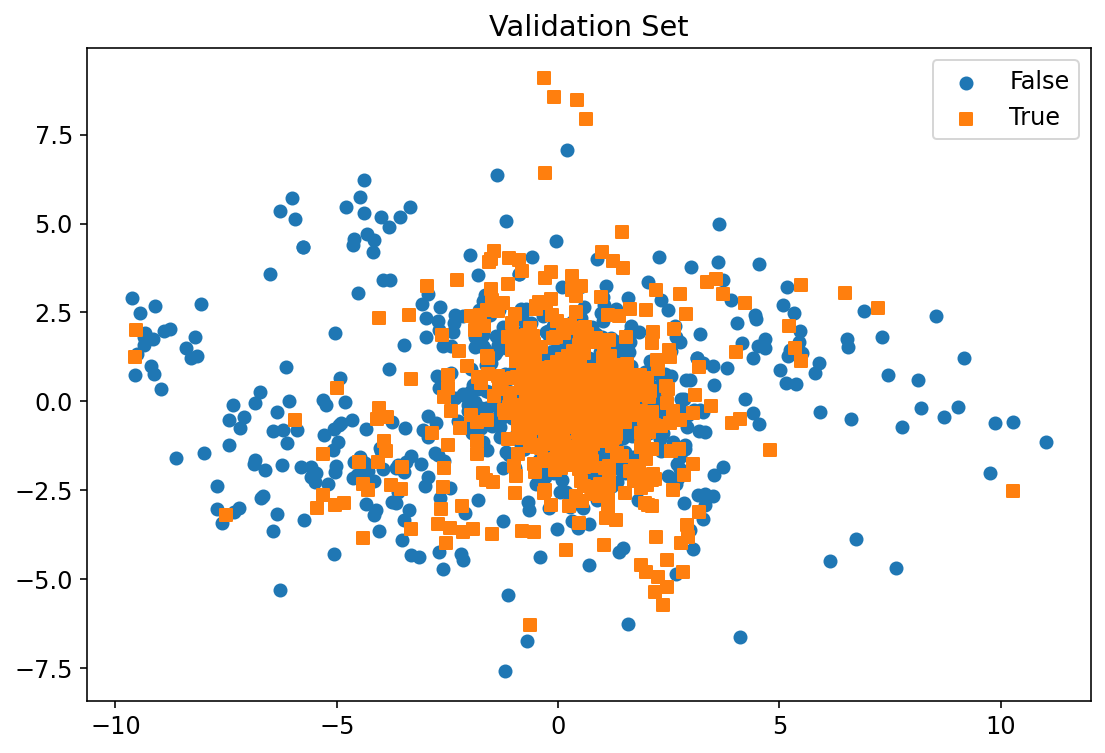

/home/marian/Escritorio/tesina/siamess/visualization.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')


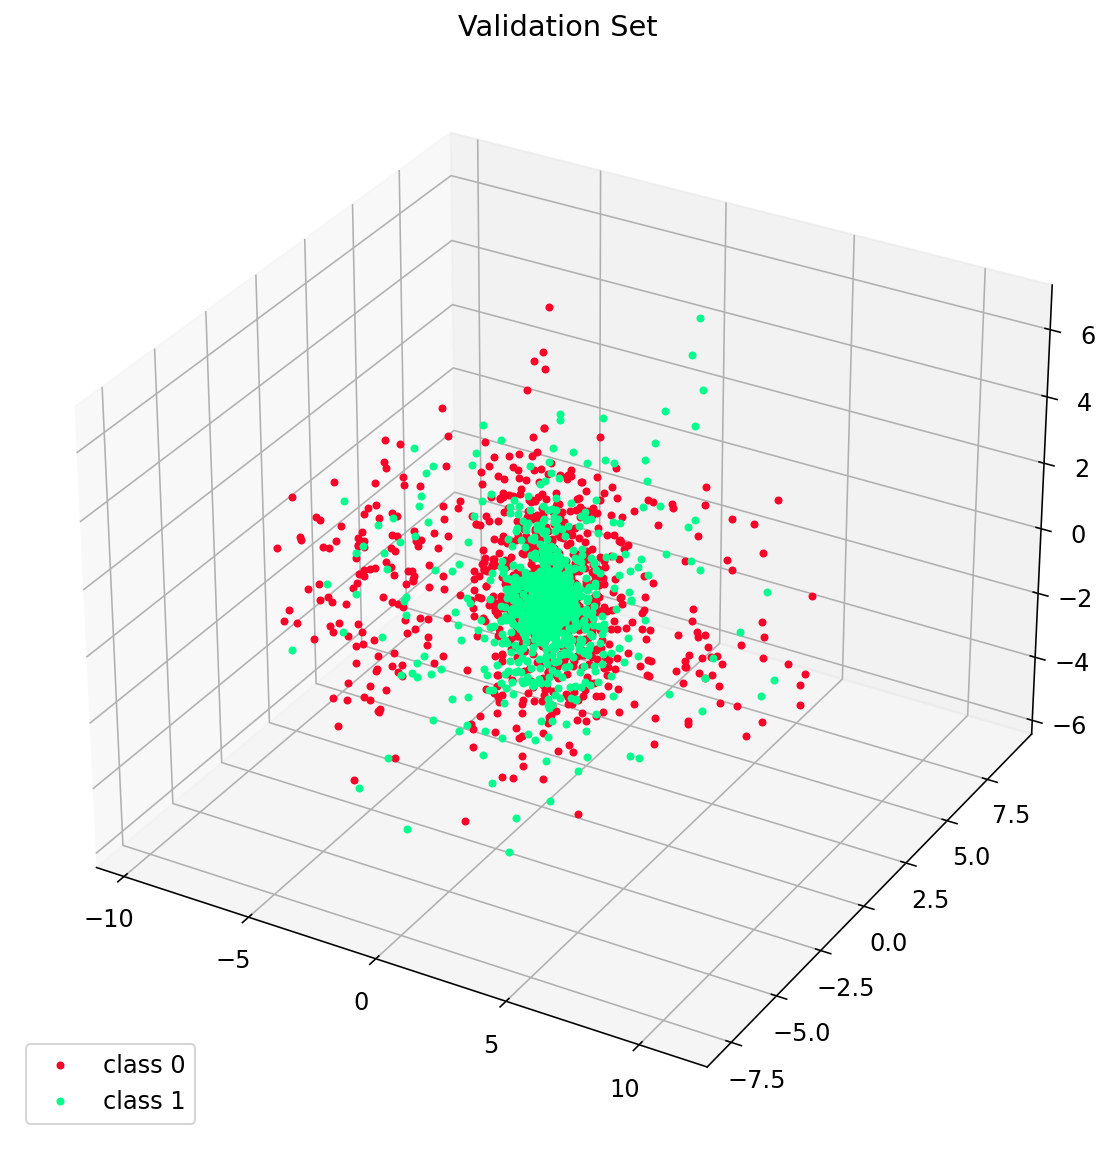

In [52]:
def plot_pcas(ns,y_filter=None):
    f = y_filter==ns.y if y_filter is not None else range(len(ns.y))
    X = ns.X[f]
    y = ns.y[f]
    X2D = PCA(n_components=2).fit_transform(X)
    plot_2d_space(X2D,y,title=ns.title)
    X3D = PCA(n_components=3).fit_transform(X)
    plotpca3d(X3D,y,title=ns.title)

plot_pcas(v)

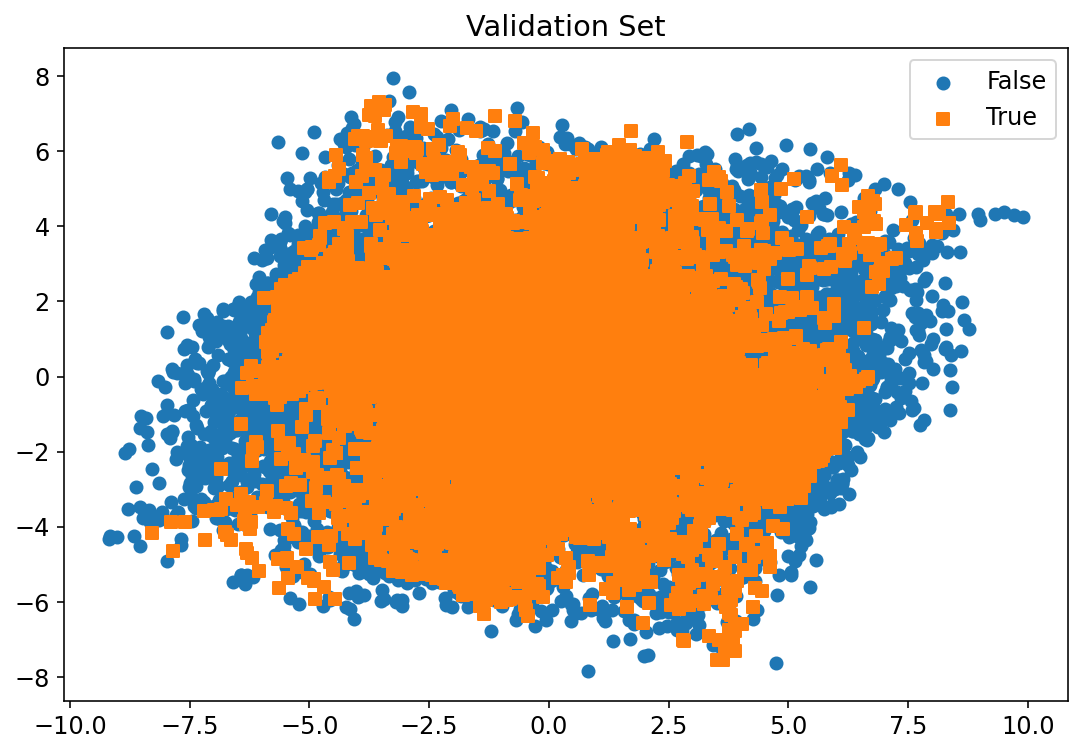

/home/marian/Escritorio/tesina/siamess/visualization.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.set_prop_cycle('color', [cm(1.*i/n_cls) for i in range(n_cls)])


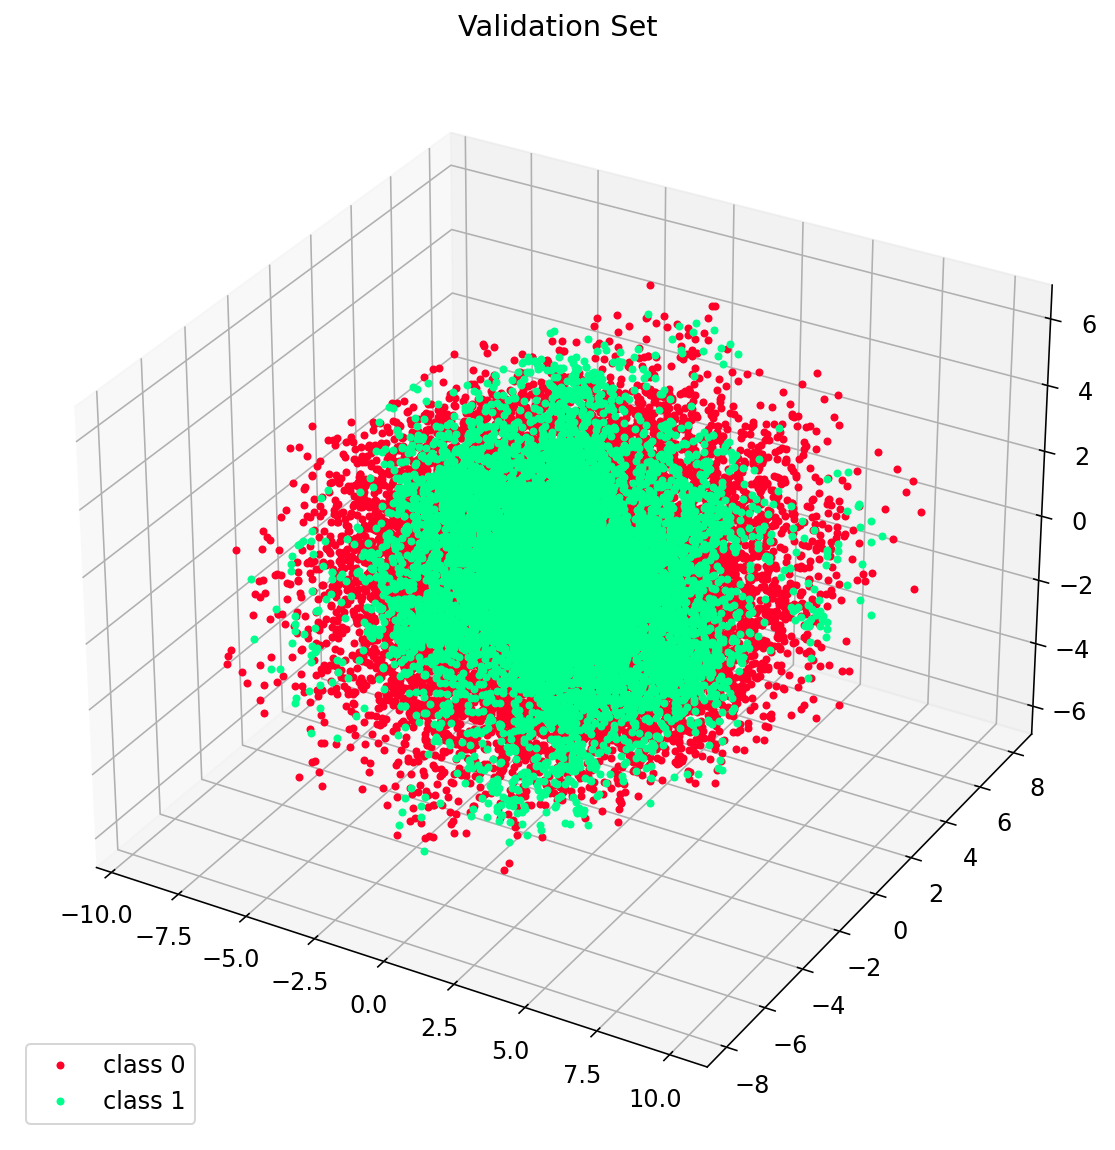

In [106]:
plot_pcas(v)

In [ ]:
b

In [61]:
m.ths

array([0.6 , 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])